# Débordements d'égouts
## Rapport final
#### Équipe 15: Jeremy Boulet, Duc-Thien Nguyen, Olivia You-Tuon et Steven Lam
#### 20 décembre 2019
---


## Table des matières

1. [Objectif](#goal)
2. [Méthode](#method)
3. [Traitement des données](#data_preprocessing)  
    3.1. [Données sur les surverses](#data_surverses)  
    3.2. [Données sur les précipitations](#data_precipitations)  
    3.3. [Données manquantes sur les précipitations](#missing_data_precipitations)  
    3.4. [Données sur les ouvrages](#data_ouvrages)
4. [Analyse exploratoire](#exploratory_analysis)  
    4.1. [Précipitation totale d'une journée pour chaque station](#pcp_sum)  
    4.2. [Précipitation horaire maximale d'une journée pour chaque station](#pcp_max)  
    4.3. [Variables explicatives choisies](#features)
5. [Modèles](#models)  
    5.1. [Régression logistique](#logistic)  
    5.2. [Classification par forêt aléatoire](#random_forest)  
    5.3. [Classification bayésienne naïve](#naive_bayesian)
6. [Améliorations possibles](#improvements)  
    6.1. [*Adapative boosting*](#adaboost)

---

<a id="goal"></a>

## 1. Objectif

L'objectif de ce projet est de prédire, à l'aide de jeux de données de la ville de Montréal, les débordements en 2019 de 5 ouvrages donnés. Dans ce rapport, nous allons expliquer notre méthodologie, nos résultats ainsi que des améliorations possibles.

<a id="method"></a>


## 2. Méthode

La méthode que nous avons retenue pour prédire les déversements est la méthode des forêts aléatoires (de l'anglais *random forest classifier*). Les variables explicatives utilisées sont les suivantes: la somme de la pluie d'une journée pour chaque station pluviométrique, le maximum horaire des précipitations d'une journée pour chaque station pluviométrique et la géolocalisation du trop-plein de l'ouvrage. À l'aide de cette méthode, nous avons eu un résultat de 0,80373 sur Kaggle.

#### Les librairies utilisées

In [1]:
using CSV, DataFrames, Statistics, Dates, Gadfly, GLM, Distributions, LinearAlgebra, DecisionTree

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273
┌ Info: Precompiling Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1273
┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1273


<a id="data_preprocessing"></a>

## 3. Traitement des données

<a id="data_surverses"></a>
### 3.1. Données sur les surverses

La cellule de code suivante permet de nettoyer les données sur les surverses avant de les utiliser. Nous avons premièrement extrait les données des mois de mai à octobre inclusivement, puisque nous voulons que les données sur la pluie et non sur la neige. Ensuite, nous allons remplacé les raisons manquantes par "Inconnue". Nous excluons ensuite les surverses causées par d'autres raisons que les précipitations. Enfin, nous excluons les rangées où la valeur "SURVERSE" est manquante.

In [2]:
# Chargement des données de surverses
data_surverse = CSV.read("data/surverses.csv",missingstring="-99999")

# Extraction des mois de mai à octobre inclusivement
data_surverse = filter(row -> month(row.DATE) > 4, data_surverse) 
data_surverse = filter(row -> month(row.DATE) < 11, data_surverse) 

# Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"
raison = coalesce.(data_surverse[:,:RAISON],"Inconnue")
data_surverse[!,:RAISON] = raison

# Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides
data_surverse = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data_surverse) 
select!(data_surverse, [:NO_OUVRAGE, :DATE, :SURVERSE])

# Exclusion des lignes où :SURVERSE est manquante
surverse_df = dropmissing(data_surverse, disallowmissing=true)
first(surverse_df,5)

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0


<a id="data_precipitations"></a>
### 3.2. Données sur les précipitations

Après le chargement des données sur les précipitations, nous faisons une extraction pour obtenir que les données pour les mois désirés (soit de mai à octobre inclusivement).

In [3]:
#### Chargement des données de précipitations
data_precipitations = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data_precipitations, Symbol("St-Hubert")=>:StHubert)

#### Extraction des précipitations des mois de mai à octobre inclusivement
data_precipitations = filter(row -> month(row.date) > 4, data_precipitations)
data_precipitations = filter(row -> month(row.date) < 11, data_precipitations)
first(data_precipitations, 5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,0,missing
2,2013-05-01,1,0,0,0,0,missing
3,2013-05-01,2,0,0,0,0,missing
4,2013-05-01,3,0,0,0,0,missing
5,2013-05-01,4,0,0,0,0,missing


<a id="missing_data_precipitations"></a>
### 3.3. Données manquantes sur les précipitations

On constate qu'il y a beaucoup de données manquantes pour les précipitations. Si nous décidons de les ignorer, cela réduira grandement la capacité de prédiction de notre modèle. De ce fait, nous avons décidé de ne pas les ignorer.

Initialement, nous avons remplacé les valeurs manquantes d'une colonne de précipitations par la moyenne de la colonne en question. Toutefois, après réflexion, ce n'est pas la meilleure manière d'approximer puisque cela aura comme effet d'indiquer qu'il y a plu à chaque journée manquante.

D'autre part, une alternative est d'utiliser le mode de la colonne, soit la valeur qui revient le plus souvent. Dans notre cas, pour chaque colonne, le mode aurait été la valeur 0. C'est une approximation qui semble quand même bonne, mais nous ne l'avons pas essayer car nous avons utilisé une méthode encore meilleure.

Enfin, nous avons décidé de les approximer en utilisant la moyenne des précipitations des autres stations pluviométriques pour la même heure de la journée (i.e. la moyenne sur la rangée des données manquantes). Cela semble être une meilleure approximation puisque s'il pleut ailleurs à Montréal à cette heure là, nous supposons qu'il y a de fortes chances qu'il pleuve aussi à la station manquante.

Nous avons écrit la fonction dans la cellule suivante pour nous aider à remplacer les valeurs manquantes par la moyenne de sa rangée. Avec deux soumissions sur Kaggle, nous avons constaté que la méthode des moyennes sur les rangées est effectivement meilleure que la méthode des moyennes sur les colonnes.

In [ ]:
# McTavish_Sum_Avg = mean(skipmissing(enhanced_surve[:,:McTavish]))
# Bellevue_Sum_Avg = mean(skipmissing(enhanced_surve[:,:Bellevue]))
# Assomption_Sum_Avg = mean(skipmissing(enhanced_surve[:,:Assomption]))
# Trudeau_Sum_Avg = mean(skipmissing(enhanced_surve[:,:Trudeau]))
# StHubert_Sum_Avg = mean(skipmissing(enhanced_surve[:,:StHubert]))

# McTavish_Max_Avg = mean(skipmissing(enhanced_surve[:,:McTavishMax]))
# Bellevue_Max_Avg = mean(skipmissing(enhanced_surve[:,:BellevueMax]))
# Assomption_Max_Avg = mean(skipmissing(enhanced_surve[:,:AssomptionMax]))
# Trudeau_Max_Avg = mean(skipmissing(enhanced_surve[:,:TrudeauMax]))
# StHubert_Max_Avg = mean(skipmissing(enhanced_surve[:,:StHubertMax]))

# replacement = [McTavish_Sum_Avg, Bellevue_Sum_Avg, Assomption_Sum_Avg, Trudeau_Sum_Avg, StHubert_Sum_Avg,
#                 McTavish_Max_Avg, Bellevue_Max_Avg, Assomption_Max_Avg, Trudeau_Max_Avg, StHubert_Max_Avg]

# # Commence a 4 pour les column des precipitations
# for i = 4:size(enhanced_surve,2)
#     for j = 1:size(enhanced_surve, 1)
#         if enhanced_surve[j,i] === missing
#             enhanced_surve[j,i] = floor(replacement[i - 3])
#         end
#     end
# end

In [15]:
# Fonction pour remplacer les missing avec la moyenne de la ligne
# data: dataframe
# nbCol: nombre de colonnes pour la moyenne
# offset: nombre de colonnes a skip avant les donnees
function rowMean(data, nbCol, offset)
    for i = 1:size(data, 1)
        sum = 0
        for j = 1:nbCol
            if data[i,j + offset] !== missing
                sum = sum + data[i,j + offset]
            end
        end
        for j = 1:nbCol
            if data[i,j + offset] === missing
                data[i,j + offset] = floor(sum/5)
            end
        end
    end
end

# Utiliser la fonction rowMean pour remplacer les valeurs manquantes par la moyenne de la rangée
rowMean(data_precipitations, 5, 2)
first(data_precipitations,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,0,0
2,2013-05-01,1,0,0,0,0,0
3,2013-05-01,2,0,0,0,0,0
4,2013-05-01,3,0,0,0,0,0
5,2013-05-01,4,0,0,0,0,0


<a id="data_ouvrages"></a>
### 3.4. Données sur les ouvrages

Après le chargement des données sur les ouvrages, nous avons extrait les coordonnées des du trop-plein de chaque ouvrage étudié. Pour les valeurs manquantes en Z, nous les avons remplacé par la moyenne des autres ouvrages. La cellule suivante présente le code pour effectuer ce traitement.

In [6]:
# Chargement des données des ouvrages
data_ouvrage = CSV.read("data/ouvrages-surverses.csv",missingstring="")

# Extraire les ouvrages étudiés seulement
df_ouvrage = filter(row ->
    row.ID_ouvrage == "3260-01D" ||
    row.ID_ouvrage == "3350-07D" ||
    row.ID_ouvrage == "4240-01D" ||
    row.ID_ouvrage == "4350-01D" ||
    row.ID_ouvrage == "4380-01D", data_ouvrage)

# Extraire les colonnes des coordonnées du Trop-Plein
df_ouvrage = df_ouvrage[:,[:ID_ouvrage, Symbol("Trop-Plein X"), Symbol("Trop-Plein Y"), Symbol("Trop-Plein Z")]]
rename!(df_ouvrage, Symbol("ID_ouvrage")=>:NO_OUVRAGE)

# Les données manquantes sont approximées par la moyenne des données présentes
meanHeight = mean(skipmissing(df_ouvrage[Symbol("Trop-Plein Z")]))
df_ouvrage[ismissing.(df_ouvrage[Symbol("Trop-Plein Z")]), Symbol("Trop-Plein Z")] .= meanHeight

df_ouvrage

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[6]:15
└ @ Core In[6]:15
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[6]:18
└ @ Core In[6]:18


,NO_OUVRAGE,Trop-Plein X,Trop-Plein Y,Trop-Plein Z
,String,Float64,Float64,Float64⍰
1,3260-01D,2.98543e5,5.05676e6,20.17
2,3350-07D,2.89801e5,5.04516e6,20.75
3,4240-01D,3.05755e5,5.05665e6,11.91
4,4350-01D,3.00503e5,5.03991e6,17.61
5,4380-01D,2.9982e5,5.03643e6,17.61


<a id="exploratory_analysis"></a>
## 4. Analyse exploratoire

<a id="pcp_sum"></a>
### 4.1. Précipitation totale d'une journée pour chaque station

Tout d'abord, nous avons calculé la somme des précipitations pour obtenir une précipitation journalière pour chaque stations pluviométriques. Ensuite, nous avons généré des diagrammes en boîte pour chaque station et pour chaque ouvrage étudiée pour observer s'il y a une tendance pertinente. Nous avons écrit une fonction *drawBoxplots* pour nous aider à générer les diagrammes.

In [7]:
# Faire la somme des precipitations par rapport a la date
pcp_sum = by(data_precipitations, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
           Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum)

function drawBoxplots(sum, ouvrage)
    ouvrage1_sum = join(ouvrage, sum, on=:date, kind=:inner)
    
    McTavish_plot = plot(ouvrage1_sum, x=:SURVERSE, y=:McTavish, Geom.boxplot)
    Bellevue_plot = plot(ouvrage1_sum, x=:SURVERSE, y=:Bellevue, Geom.boxplot)
    Assomption_plot = plot(ouvrage1_sum, x=:SURVERSE, y=:Assomption, Geom.boxplot)
    Trudeau_plot = plot(ouvrage1_sum, x=:SURVERSE, y=:Trudeau, Geom.boxplot)
    StHubert_plot = plot(ouvrage1_sum, x=:SURVERSE, y=:StHubert, Geom.boxplot)

    draw(SVGJS(30cm, 15cm), hstack([McTavish_plot, Bellevue_plot, Assomption_plot, Trudeau_plot, StHubert_plot]))
end

drawBoxplots (generic function with 1 method)

La cellule de code suivante permet d'afficher les diagrammes en boîte de chaque station. On constate que lorsqu'il y a une surverse à une station, le total des précipitations de la journée à cette station tend à être élevé. Nous choisissons donc d'utiliser cette variable comme variable explicative dans notre projet.

In [ ]:
ouvrage1 = filter(row -> row.NO_OUVRAGE == "3260-01D", surverse_df)
rename!(ouvrage1, Symbol("DATE")=>:date)
drawBoxplots(pcp_sum, ouvrage1)

ouvrage2 = filter(row -> row.NO_OUVRAGE == "3350-07D", surverse_df)
rename!(ouvrage2, Symbol("DATE")=>:date)
drawBoxplots(pcp_sum, ouvrage2)

ouvrage3 = filter(row -> row.NO_OUVRAGE == "4240-01D", surverse_df)
rename!(ouvrage3, Symbol("DATE")=>:date)
drawBoxplots(pcp_sum, ouvrage3)

ouvrage4 = filter(row -> row.NO_OUVRAGE == "4350-01D", surverse_df)
rename!(ouvrage4, Symbol("DATE")=>:date)
drawBoxplots(pcp_sum, ouvrage4)

ouvrage5 = filter(row -> row.NO_OUVRAGE == "4380-01D", surverse_df)
rename!(ouvrage5, Symbol("DATE")=>:date)
drawBoxplots(pcp_sum, ouvrage5)

<a id="pcp_max"></a>
### 4.2. Précipitation horaire maximale d'une journée pour chaque station

Nous avons aussi identifier la valeur maximale des précipitations horaires à chaque jour pour chaque station. Nous avons également afficher les diagrammes en boîte. La cellule suivante permet d'afficher les diagrammes.

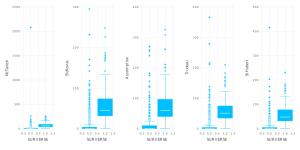

In [18]:
# Identifier le maximum des precipitations pour chaque jour
pcp_max = by(data_precipitations, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)

drawBoxplots(pcp_max, ouvrage1)
drawBoxplots(pcp_max, ouvrage2)
drawBoxplots(pcp_max, ouvrage3)
drawBoxplots(pcp_max, ouvrage4)
drawBoxplots(pcp_max, ouvrage5)

D'après les diagrammes précédents, nous constatons à nouveau une tendance. En effet, lorsqu'il y a une surverse à une station donnée, la précipitation horaire maximale tend à être plus élevée. Nous utiliserons donc cette variable comme variable explicative dans notre projet.

<a id="features"></a>
### 4.3. Variables explicatives choisies

D'après notre analyse des données fournies par l'énnoncé, nous avons déterminé que nos variables explicatives sont:

__Les sommes__ :
- __Somme McTavish__ : Somme des précipitations de la journée pour la station McTavish.
- __Somme Bellevue__ : Somme des précipitations de la journée pour la station de Bellevue.
- __Somme Trudeau__ : Somme des précipitations de la journée pour la station de Trudeau.
- __Somme St-Hubert__ : Somme des précipitations de la journée pour la station de St-Hubert.
- __Somme Assomption__ : Somme des précipitations de la journée pour la station de Assomption.

__Les maximums__ :
- __Max McTavish__ : Maximum horaire de précipitation de la journée pour la station McTavish.
- __Max Bellevue__ : Maximum horaire de précipitation de la journée pour la station Bellevue.
- __Max Trudeau__ : Maximum horaire de précipitation de la journée pour la station Trudeau.
- __Max St-Hubert__ : Maximum horaire de précipitation de la journée pour la station St-Hubert.
- __Max Assomption__ : Maximum horaire de précipitation de la journée pour la station Assomption.

__Les données des ouvrages__:
- __Trop plein X__: Coordonnée UTM en X du trop-plein.
- __Trop plein Y__: Coordonnée UTM en Y du trop-plein.
- __Trop plein Z__: Hauteur en Z du tube d'évacuation du trop-plein.

<a id="models"></a>
## 5. Modèles

Nous avons essayé plusieurs méthodes pour créer notre modèle de prédiction. Dans cette section, nous allons présenté les différentes méthodes que nous avons utilisées et les raisons pour lesquelles nous avons abandonné ou conservé la méthode en question.

<a id="logistic"></a>
### 5.1. Régression logistique


<a id="random_forest"></a>
### 5.2. Classification par forêt aléatoire


<a id="naive_bayesian"></a>
### 5.3. Classification bayésienne naïve


<a id="improvements"></a>
## 6. Améliorations possibles

<a id="adaboost"></a>
### 6.1. *Adaptative boosting*